In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

# Initialization

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

mappy = False  ### if the Net isn't originally mapped -> False
rgb = False
mod_init = False
act_fun = nn.LeakyReLU
loader_path = './model_optim_110.pt'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

spada e scuda


In [3]:
class GalaxyJungle(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mappy=False, is_rgb=False):
        self.rgb = is_rgb
        self.mappy = mappy
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
    
    def __len__(self): return (self.img_labels).shape[0]

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        if self.transform: image = self.transform(image)
        
        label = self.img_labels.iloc[idx, 1:]        
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.mappy: label = zk.mappy(label)

        gal_id = self.img_labels.iloc[idx, 0]

        return image, label, gal_id

In [4]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, mappy=False, is_rgb=False):
        super().__init__()
        
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()



    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


# Validation Labels

In [5]:
training_sample = zk.mappy_df(pd.read_csv('../data/validation/validation_solutions_rev1.csv'))
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
# display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())
display(training_sample.groupby('train_label').size())

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A             17
E0          2309
E3          2862
E6           511
S0a_eon      724
SAa            8
SAb          436
SAc          955
SAd           39
SB0a_eon      10
SBa            5
SBb          218
SBc          213
SBd           17
Scd_eon      326
SoA         2075
SoB          359
dtype: int64

# Training Labels

In [6]:
training_sample = zk.mappy_df(pd.read_csv('../data/training/training_solutions_rev1.csv'))
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
# display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())
display(training_sample.groupby('train_label').size())

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A              82
E0           9122
E3          11209
E6           2153
S0a_eon      3080
SAa            49
SAb          1815
SAc          3716
SAd           164
SB0a_eon       46
SBa             6
SBb           867
SBc           886
SBd            48
Scd_eon      1384
SoA          8376
SoB          1333
dtype: int64

# Model Predicition on Test Labels

In [7]:
DS = GalaxyJungle('../data/test/test_solutions_rev1.csv', '../data/test/', transform, mappy=True, is_rgb=rgb)
test_loader = DataLoader(DS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

model = GalaxyNet(act_fun, initialization=mod_init, mappy=mappy, is_rgb=rgb).to(device)
loader = torch.load(loader_path, weights_only=True)
model.load_state_dict(loader['model_state_dict'])


tens=torch.empty((0,18),dtype=torch.float32)
model.eval()
loss = 0
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, GalaxyID = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = nn.ReLU()(model(inputs))
            if not mappy: outputs = zk.mappy2D(outputs)
            loss += np.sqrt(nn.MSELoss()(outputs, labels).item())
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID,outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)
print('Test loss', loss/len(test_loader))

Convs output size: 2


13it [00:07,  1.65it/s]

Test loss 0.060448818232772705


In [8]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)

true_results = zk.mappy_df(pd.read_csv('../data/test/test_solutions_rev1.csv'))
true_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
true_results['true_label'] = true_results.iloc[:,1:].idxmax(axis=1)
true_results['true_value'] = true_results.iloc[:,1:-1].max(axis=1)

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


In [10]:
b = true_results.drop(columns=['true_label','true_value']).to_numpy()
l = []
for i in b:
    l.append(sorted(i, reverse=True)[:3])
    x = pd.DataFrame(l, columns=['GalaxyID','max1','max2'])
x['difference'] = x['max1'] - x['max2']
true_results['difference'] = x['difference'].values
true_skim = true_results[true_results['difference'] > 0.1]

In [11]:
confronto = pd.merge(train_results[['GalaxyID', 'train_label']], true_skim[['GalaxyID', 'true_label']], on='GalaxyID')
total_count = confronto.groupby('true_label').size().reset_index(name='total_count')
mislabels = confronto[confronto['train_label'] != confronto['true_label']]

count = mislabels.groupby('true_label').size().reset_index(name='num_misclassified').sort_values(by='num_misclassified', ascending=False)

final_count2 = pd.merge(total_count, count, on='true_label', how='left').sort_values(by='num_misclassified', ascending=False)
final_count2['score'] = np.round((1 - final_count2['num_misclassified'] / final_count2['total_count']), 2) * 100
final_count2.sort_values(by='score', ascending=False, inplace=True)
display(final_count2)

,true_label,total_count,num_misclassified,score
1,E0,1064,48.0,95.0
2,E3,1182,138.0,88.0
7,SAc,337,59.0,82.0
4,S0a_eon,292,52.0,82.0
3,E6,170,48.0,72.0
13,Scd_eon,111,32.0,71.0
6,SAb,142,53.0,63.0
11,SBc,66,27.0,59.0
15,SoB,119,54.0,55.0
10,SBb,65,30.0,54.0


In [12]:
# final_count.to_csv('tables_count/JAGZoo_whole.csv', index=False, sep='&', lineterminator='\\\\\n')
# final_count2.to_csv('PADel_skim.csv', index=False, sep='&', lineterminator='\\\\\n')

# Confusion Matrices

In [13]:
y = confronto
all_classes = ['E0', 'E3','E6','S0A', 'S0B', 'S0a_eon', 'SB0a_eon', 'Scd_eon', 'SAa','SAb', 'SAc', 'SAd', 'SBa', 'SBb', 'SBc', 'SBd', 'A']
yy = y.groupby(['true_label', 'train_label']).size().reset_index(name = 'count')

all_in_column = set(all_classes).issubset(set(yy['true_label']))
print("All items in list are in the column:", all_in_column)
missing_true = set(all_classes) - set(yy['true_label'])
missing_train = set(all_classes) - set(yy['train_label'])
print(missing_true,missing_train)
for i in missing_true:
    for j in missing_train:
        yy = pd.concat([yy,pd.DataFrame([{'true_label': i, 'train_label': j, 'count': 0.1}])], ignore_index=True )

All items in list are in the column: False
{'S0B', 'SBa', 'S0A'} {'S0B', 'S0A', 'SBa', 'SAa', 'SB0a_eon'}


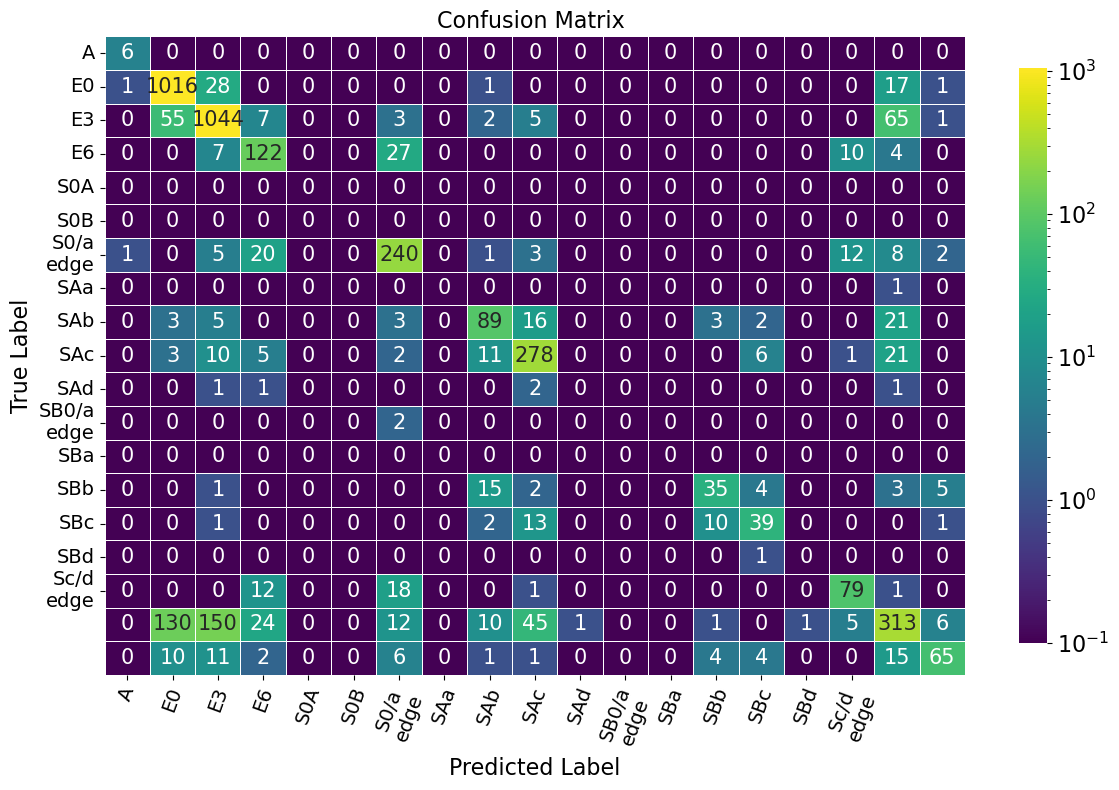

In [ ]:
heatmap_data = yy.pivot(index='true_label', columns='train_label', values='count').fillna(0.1)
heatmap_data = heatmap_data[all_classes]
heatmap_data = heatmap_data.loc[all_classes]
label_classes = ['E0', 'E3','E6','S0A', 'S0B', 'SAa','SAb', 'SAc', 'SAd', 'SBa', 'SBb', 'SBc', 'SBd','S0/a e/o', 'S0B/a e/o', 'Sc/d e/o', 'A']
ticks = np.arange(0,17)+0.5
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data,
                annot=True,
                annot_kws= {'fontsize': 12},
                fmt='.0f',
                cmap='viridis',
                norm= LogNorm(vmin=0.1, vmax=heatmap_data.values.max()),
                square=True,
                linewidths=0.4,
                cbar_kws={'label': 'Count', 'shrink':0.9},
                )
plt.title('Confusion Matrix: PADel ', fontsize=16)
plt.xticks(ticks=ticks,labels=label_classes,rotation=90)
plt.yticks(ticks=ticks,labels=label_classes,rotation=0)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
ax.tick_params(labelsize=14)
cbar.set_label('', fontsize=16)
plt.tight_layout()
plt.savefig('confusion_padel.png', dpi=500, bbox_inches='tight')
plt.show()